<a href="https://colab.research.google.com/github/ngca1011/sentiment-classifier/blob/main/sentiment_classification_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Review:
    def __init__(self, text, score):
        self.text = str(text)
        self.score = score
        self.sentiment = self.get_sentiment()

    def get_sentiment(self):
        if (self.score >= 3):
            return "POSITIVE"
        else:
            return "NEGATIVE"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Extract data

In [3]:
filename = "/content/drive/MyDrive/Colab Notebooks/data/Books_rating.csv"
import pandas as pd
df = pd.read_csv(filename, nrows = 120000)

### Cleansing data

In [4]:
df[['review/text', 'review/score']].isnull().sum()
df['review/text'].dropna(inplace = True)

### Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

reviews = [Review(df.loc[i]['review/text'], df.loc[i]['review/score']) for i in range(len(df))]

X = [x.text for x in reviews]
y = [y.sentiment for y in reviews]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 2)

### Text preprocessing

In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# https://stackoverflow.com/questions/66044999/remove-stopwords-in-tensorflow-extended
def parse_text(text):
    text = re.sub("[^a-zA-Z]", ' ', text) # Remove punctuation and numbers

    text = text.lower().split() # Lowercase and split

    swords = set(stopwords.words("english"))
    text = [w for w in text if w not in swords] # Remove stop words

    text = " ".join(text)
    return text

X_train = [parse_text(text) for text in X_train]
X_test = [parse_text(text) for text in X_test]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Tokenize and pad the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print(X_train[0])
print(X_train_sequences[0])

max_len = max(len(seq) for seq in X_train_sequences)

X_train_padded = pad_sequences(X_train_sequences, maxlen = max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_len)

first write review shall constructively credic negative reviews book great unlike others believe plot th part quite original paolini great job keeping story interesting whole book also good job steady maturing eragon read reviews say paolini copied tolkien george lucas etc however agree one many rags riches characters stories mean copy others eregon resemble skywalker maybe little bit mean copied idea tolkien remember scholar lore expert celtic mythology like take far tolkien stole idea celts paolini stole idea celtic mythology tolkien tolkien expert would safe trust ideas one last thing sure everybody critizing taken literature course remember leatherstocking tales considered basis american heros including huck finn though twain would likely deny etc american novels stole cooper author leatherstocking tales summaryeragon original novel original make automatically bad story paolini combined ideas best traditional ideas create great novel
[14, 256, 230, 2444, 28718, 70823, 1118, 320, 1,

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode labels ('POSITIVE' and 'NEGATIVE') to numerical values (1 and 0)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

### Train the model

In [9]:
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential()

# Layers for training
model.add(Embedding(input_dim = len(tokenizer.word_index) + 1,
                    output_dim = 100,
                    input_length = max_len)) # Input layer
model.add(Dropout(0.8)) # Dropout layer
model.add(LSTM(units = 100,
               return_sequences = False)) # LSTM layer
model.add(Dense(units = 128,
                activation = 'relu',
                kernel_regularizer = regularizers.l2(0.1))) # L2 regularizer
model.add(Dense(units = 1,
                activation = 'sigmoid')) # Output layer

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = losses.BinaryCrossentropy(from_logits=False),
              metrics = tf.metrics.BinaryAccuracy(threshold=0.5))

# Early stopping
callback = EarlyStopping(monitor = 'val_loss',
                         patience = 3,
                         restore_best_weights = True)

# Start to train the model
history = model.fit(X_train_padded,
                    y_train_encoded,
                    epochs = 15,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [callback])

Epoch 1/15
2400/2400 [==============================] - 407s 168ms/step - loss: 0.5369 - binary_accuracy: 0.8832 - val_loss: 0.2524 - val_binary_accuracy: 0.9072
Epoch 2/15
2400/2400 [==============================] - 265s 110ms/step - loss: 0.2239 - binary_accuracy: 0.9159 - val_loss: 0.2224 - val_binary_accuracy: 0.9176
Epoch 3/15
2400/2400 [==============================] - 282s 118ms/step - loss: 0.1887 - binary_accuracy: 0.9292 - val_loss: 0.2157 - val_binary_accuracy: 0.9174
Epoch 4/15
2400/2400 [==============================] - 249s 104ms/step - loss: 0.1632 - binary_accuracy: 0.9418 - val_loss: 0.2192 - val_binary_accuracy: 0.9170
Epoch 5/15
2400/2400 [==============================] - 246s 102ms/step - loss: 0.1455 - binary_accuracy: 0.9485 - val_loss: 0.2483 - val_binary_accuracy: 0.9208
Epoch 6/15
2400/2400 [==============================] - 246s 103ms/step - loss: 0.1295 - binary_accuracy: 0.9543 - val_loss: 0.2385 - val_binary_accuracy: 0.9179


### Plot the model's evaluation

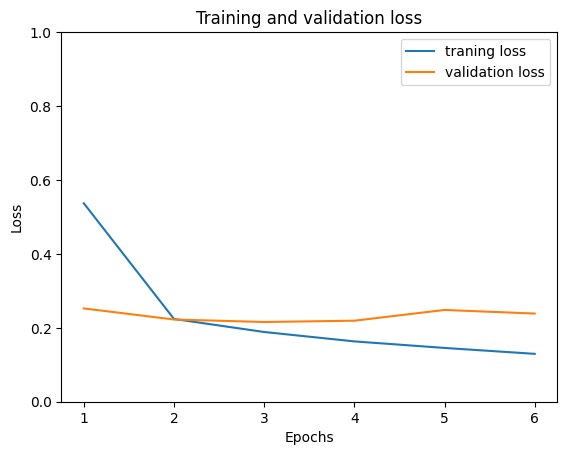

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], label = 'traning loss')
plt.plot(epochs, history.history['val_loss'], label = 'validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

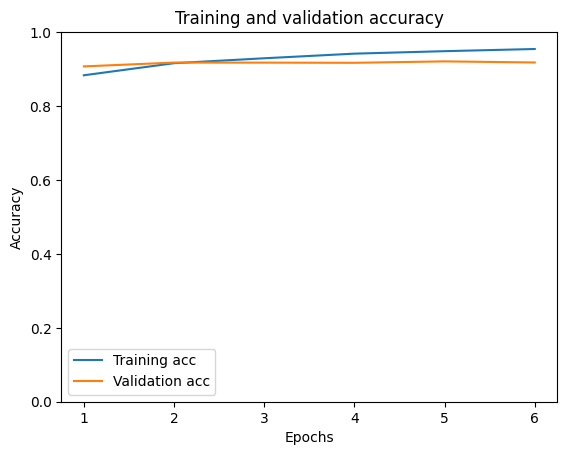

In [11]:
plt.plot(epochs, history.history['binary_accuracy'], label='Training acc')
plt.plot(epochs, history.history['val_binary_accuracy'], label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

### Test

In [12]:
# Evaluate the model on the test set
results = model.evaluate(X_test_padded, y_test_encoded)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

750/750 [==============================] - 26s 35ms/step - loss: 0.2180 - binary_accuracy: 0.9161
Test Loss: 0.21797145903110504
Test Accuracy: 0.9161249995231628


In [13]:
def convert(p):
    if (p < 0.5): return 'NEGATIVE'
    else: return 'POSITIVE'
new_test = ['I would never recommend it to anyone, pretty much uncreative and not worth it',
            'Bad horrible book, you should avoid it to not waste money on silly content',
            'Not a good material overall, but acceptable',
            'I enjoyed it a lot, i hope i see more similar books in the future!',
            'Amazing book, i rated it 5 star !!',
            'This book is a masterpiece!',
            'What a waste of time']
new_test_sequences = tokenizer.texts_to_sequences(new_test)
new_test_padded = pad_sequences(new_test_sequences, maxlen=max_len)

predictions = [convert(p) for p in model.predict(new_test_padded)]
print(predictions)

1/1 [==============================] - 1s 647ms/step
['POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE']
